In [1]:
"""
This script reads the .bio file and plots the acquired signal.


Copyright 2023 Mattia Orlandi, Pierangelo Maria Rapa

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import struct
import sys

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.signal import butter, filtfilt
#define butter lowpass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Define the bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply the bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

#apply the lowpass filter   
def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)  
    y = filtfilt(b, a, data, axis=0)
    return y
#define notch filter
def notch_filter(data, fs, f0, Q):
    nyq = 0.5 * fs
    low = f0 - (f0 / Q)
    high = f0 + (f0 / Q)
    b, a = butter(2, [low / nyq, high / nyq], btype='bandstop')
    y = filtfilt(b, a, data, axis=0)
    return y

def read_bio_file(file_path: str) -> dict:
    """
    Parameters
    ----------
    file_path : str
        Path to the .bio file.

    Returns
    -------
    dict
        Dictionary containing timestamp, signals and trigger.
    """
    dtypeMap = {
        "?": np.dtype("bool"),
        "b": np.dtype("int8"),
        "B": np.dtype("uint8"),
        "h": np.dtype("int16"),
        "H": np.dtype("uint16"),
        "i": np.dtype("int32"),
        "I": np.dtype("uint32"),
        "q": np.dtype("int64"),
        "Q": np.dtype("uint64"),
        "f": np.dtype("float32"),
        "d": np.dtype("float64"),
    }

    # Read data
    with open(file_path, "rb") as f:
        # Read number of signals
        n_signals = struct.unpack("<I", f.read(4))[0]

        # Read other metadata
        fs_base, n_samp_base = struct.unpack("<fI", f.read(8))
        signals = {}
        for _ in range(n_signals):
            sig_name_len = struct.unpack("<I", f.read(4))[0]
            sig_name = struct.unpack(f"<{sig_name_len}s", f.read(sig_name_len))[
                0
            ].decode()
            fs, n_samp, n_ch, dtype = struct.unpack("<f2Ic", f.read(13))
            dtype = dtypeMap[dtype.decode("ascii")]

            # Initialize signal array
            signals[sig_name] = {
                "fs": fs,
                "n_samp": n_samp,
                "n_ch": n_ch,
                "dtype": dtype,
            }

        # Read whether the trigger is available
        is_trigger = struct.unpack("<?", f.read(1))[0]

        # Read actual signals:
        # 1. Timestamp
        ts = np.frombuffer(f.read(8 * n_samp_base), dtype=np.float64).reshape(
            n_samp_base, 1
        )
        signals["timestamp"] = {"data": ts, "fs": fs_base}

        # 2. Signals data
        for sig_name, sig_data in signals.items():
            if sig_name == "timestamp":
                continue

            n_samp = sig_data.pop("n_samp")
            n_ch = sig_data.pop("n_ch")
            dtype = sig_data.pop("dtype")
            data = np.frombuffer(
                f.read(dtype.itemsize * n_samp * n_ch), dtype=dtype
            ).reshape(n_samp, n_ch)
            sig_data["data"] = data

        # 3. Trigger (optional)
        if is_trigger:
            trigger = np.frombuffer(f.read(), dtype=np.int32).reshape(n_samp_base, 1)
            signals["trigger"] = {"data": trigger, "fs": fs_base}

    return signals


In [2]:
#move each audio data 100 ms backward in time and pad the end with zeros
def pad_audio_data(audio_data, sr, pad_time=0.1):
    """
    Pad the audio data with zeros at the end.
    :param audio_data: Audio time series.
    :param sr: Sample rate.
    :param pad_time: Time to pad in seconds.
    :return: Padded audio data.
    """
    pad_length = int(pad_time * sr)
    padded_audio = np.pad(audio_data, (0, pad_length), mode='constant')
    return padded_audio

def move_audio_data_backward(audio_data, sr, move_time=0.1):
    """
    Move the audio data backward in time.
    :param audio_data: Audio time series.
    :param sr: Sample rate.
    :param move_time: Time to move backward in seconds.
    :return: Moved audio data.
    """
    move_length = int(move_time * sr)
    moved_audio = np.roll(audio_data, -move_length)
    moved_audio[-move_length:] = 0  # Set the last 'move_length' samples to zero
    return moved_audio

In [3]:
def decode_trigger(trigger_value):
    sentence_index = (trigger_value // 1000) - 1
    repetition = (trigger_value % 1000) // 10
    is_voiced = (trigger_value % 10) == 1
    return sentence_index, repetition, is_voiced

In [5]:
emg_data = read_bio_file(r"C:\Users\pierangelo\Downloads\Data_Grace_DIff_Dome_Dates_2025-08-29_15-39-46.bio")
# Extract the EMG signal
emg_signal = emg_data["emg"]["data"]
battery = emg_data["battery"]["data"] if "battery" in emg_data else None

audio_data = read_bio_file(r"C:\Users\pierangelo\Documents\silent_speech\dates_grace\audio_diff_8chs_2025-07-22_18-50-39.bio")
trigger = audio_data["trigger"]["data"] if "trigger" in audio_data else None
audio_signal = audio_data["audio"]["data"]
ts_audio = audio_data["timestamp"]["data"]
ts_emg = emg_data["ts"]["data"].astype(np.float64)/1_000_000
ts_emg = emg_data["timestamp"]["data"]
#apply bandpass filter to emg signal
emg_signal = bandpass_filter(emg_signal, 20, 300, emg_data["emg"]["fs"], order=4)
#aply notch filter to emg signal
emg_signal = notch_filter(emg_signal, emg_data["emg"]["fs"], 60, 30)
emg_signal = emg_signal*1000*3/12

In [6]:
emg_signal.shape

(3559600, 8)

In [6]:
trigger = np.array(
            list(
                map(
                    lambda x: decode_trigger(x[0]),
                    trigger,
                )
            )
        )
        # Unpack the decoded trigger values
sentence_index, repetition, is_voiced = zip(*trigger)

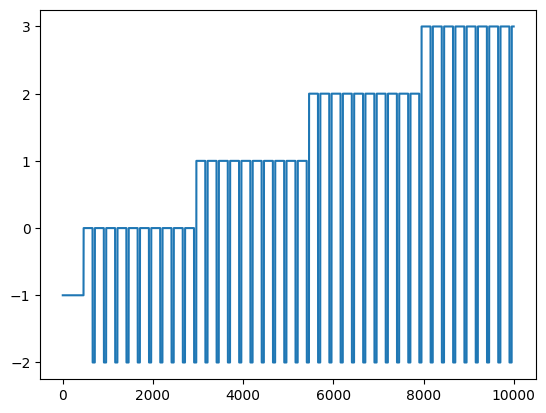

In [12]:
plt.plot(sentence_index[:10000])

In [8]:
sentence_index = np.array(sentence_index)
repetition = np.array(repetition)   
is_voiced = np.array(is_voiced)
#print shape of the variables
print(f"Sentence index shape: {sentence_index.shape}")

Sentence index shape: (78607,)


In [9]:
audio_signal = audio_signal[int(0.16*audio_data["audio"]["fs"]):]



In [10]:
trigger_change = np.where(np.diff(repetition.flatten()) != 0)[0] + 1


In [11]:
#use the trigger signal to separate each utterance in the audio signal and plot them separately
# crete a list of unique values of triggers
trigger_values = []
utterances_audio_voiced = []
utterances_audio_silent = []
utterances_emg_silent = []
utterances_emg_voiced = []
first_rep = 0
trigger_change = np.where(np.diff(repetition.flatten()) != 0)[0] + 1
#iterate over trigger change dimensione in step of 2
for i in range(0, len(trigger_change[:-1]), 2):
    
    if is_voiced[trigger_change[i]] == 1:
        print('voiced')
        if repetition[trigger_change[i]] == 1:
            first_rep = i
        start_emg = trigger_change[i] 
        end_emg = trigger_change[i + 1]
        start_ts_emg = ts_audio[start_emg] - 0.5
        stop_ts_emg = ts_audio[end_emg] 
        start_audio = trigger_change[i] 
        end_audio = trigger_change[i+1]
        start_ts_audio = ts_audio[start_audio] -0.5
        stop_ts_audio = ts_audio[end_audio]
        start_idx_emg = np.abs(ts_emg - start_ts_emg).argmin(axis=0).item()
        start_idx_audio = np.abs(ts_audio - start_ts_audio).argmin(axis=0).item()
        stop_idx_emg = np.abs(ts_emg - stop_ts_emg).argmin(axis=0).item()
        stop_idx_audio = np.abs(ts_audio - stop_ts_audio).argmin(axis=0).item()
        start_idx_trigger = np.abs(ts_audio - start_ts_emg).argmin(axis=0).item()
        stop_idx_trigger = np.abs(ts_audio - stop_ts_emg).argmin(axis=0).item()
        trigger_values.append(np.unique(trigger[start_idx_trigger:stop_idx_trigger])[-1])
        utterances_audio_voiced.append(audio_signal[start_idx_audio*960:stop_idx_audio*960])
        print(start_idx_emg, stop_idx_emg)
        print(start_idx_audio, stop_idx_audio)

        utterances_emg_voiced.append(emg_signal[start_idx_emg*200:stop_idx_emg*200])
    else:
        print('silent')
        start_emg = trigger_change[i] 
        end_emg = trigger_change[i + 1]
        start_ts_emg = ts_audio[start_emg] - 0.5
        stop_ts_emg = ts_audio[end_emg] 
        start_audio = trigger_change[first_rep] 
        end_audio = trigger_change[first_rep+1]
        start_ts_audio = ts_audio[start_audio] -0.5
        stop_ts_audio = ts_audio[end_audio]
        start_idx_emg = np.abs(ts_emg - start_ts_emg).argmin(axis=0).item()
        start_idx_audio = np.abs(ts_audio - start_ts_audio).argmin(axis=0).item()
        stop_idx_emg = np.abs(ts_emg - stop_ts_emg).argmin(axis=0).item()
        stop_idx_audio = np.abs(ts_audio - stop_ts_audio).argmin(axis=0).item()
        start_idx_trigger = np.abs(ts_audio - start_ts_emg).argmin(axis=0).item()
        stop_idx_trigger = np.abs(ts_audio - stop_ts_emg).argmin(axis=0).item()
        trigger_values.append(np.unique(trigger[start_idx_trigger:stop_idx_trigger])[-1])
        utterances_audio_silent.append(audio_signal[start_idx_audio*960:stop_idx_audio*960])
        print(start_idx_emg, stop_idx_emg)
        print(start_idx_audio, stop_idx_audio)
        utterances_emg_silent.append(emg_signal[start_idx_emg*200:stop_idx_emg*200])

voiced
26 70
436 661
voiced
75 121
686 911
voiced
125 170
937 1161
silent
176 220
436 661
silent
225 270
436 661
silent
275 320
436 661
silent
325 370
436 661
silent
375 420
436 661
silent
425 470
436 661
silent
475 520
436 661
voiced
525 570
2936 3161
voiced
575 620
3186 3410
voiced
624 669
3435 3660
silent
674 719
2936 3161
silent
724 769
2936 3161
silent
774 819
2936 3161
silent
824 869
2936 3161
silent
874 919
2936 3161
silent
924 969
2936 3161
silent
974 1018
2936 3161
voiced
1023 1068
5435 5660
voiced
1073 1118
5685 5910
voiced
1123 1168
5935 6160
silent
1173 1218
5435 5660
silent
1223 1268
5435 5660
silent
1273 1318
5435 5660
silent
1323 1367
5435 5660
silent
1372 1417
5435 5660
silent
1422 1467
5435 5660
silent
1472 1517
5435 5660
voiced
1522 1567
7930 8156
voiced
1571 1616
8180 8405
voiced
1622 1666
8430 8655
silent
1672 1716
7930 8156
silent
1721 1766
7930 8156
silent
1771 1816
7930 8156
silent
1821 1866
7930 8156
silent
1871 1916
7930 8156
silent
1921 1965
7930 8156
silent
1

In [12]:
#cut every utterance in utterances_emg_silent in 8000 samples
utterances_emg_silent_cut = []
utterances_emg_voiced_cut = []
utterances_audio_silent_cut = []
utterances_audio_voiced_cut = []
for i, utterance in enumerate(utterances_audio_voiced):
    if utterance.shape[0] > 8000*960:
        utterances_audio_voiced_cut.append(utterance[: 8000*960, :])
    else:
        utterances_audio_voiced_cut.append(np.pad(utterance, ((0,  8000*960 - utterance.shape[0]), (0, 0)), mode='constant'))
for i, utterance in enumerate(utterances_audio_silent):
    if utterance.shape[0] > 8000:
        utterances_audio_silent_cut.append(utterance[:8000, :])
    else:
        utterances_audio_silent_cut.append(np.pad(utterance, ((0, 8000 - utterance.shape[0]), (0, 0)), mode='constant'))
for i, utterance in enumerate(utterances_emg_voiced):       
    if utterance.shape[0] > 8000:
        utterances_emg_voiced_cut.append(utterance[:8000, :])
    else:
        utterances_emg_voiced_cut.append(np.pad(utterance, ((0, 8000 - utterance.shape[0]), (0, 0)), mode='constant'))
for i, utterance in enumerate(utterances_emg_silent):       
    if utterance.shape[0] > 8000:
        utterances_emg_silent_cut.append(utterance[:8000, :])
    else:
        utterances_emg_silent_cut.append(np.pad(utterance, ((0, 8000 - utterance.shape[0]), (0, 0)), mode='constant'))


In [13]:
silent_emg = np.stack(utterances_emg_silent_cut[:], axis=0)
voiced_emg = np.stack(utterances_emg_voiced_cut[:], axis=0)

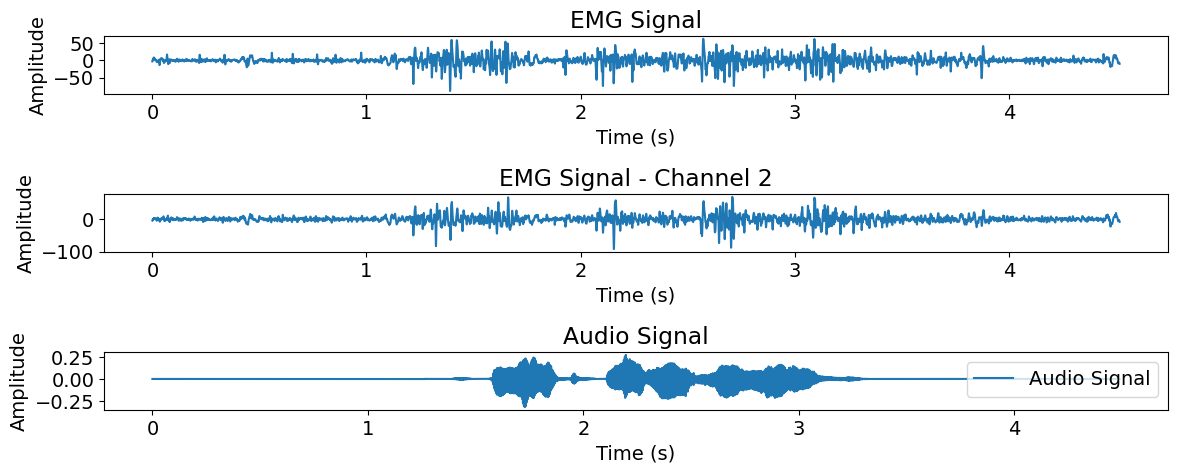

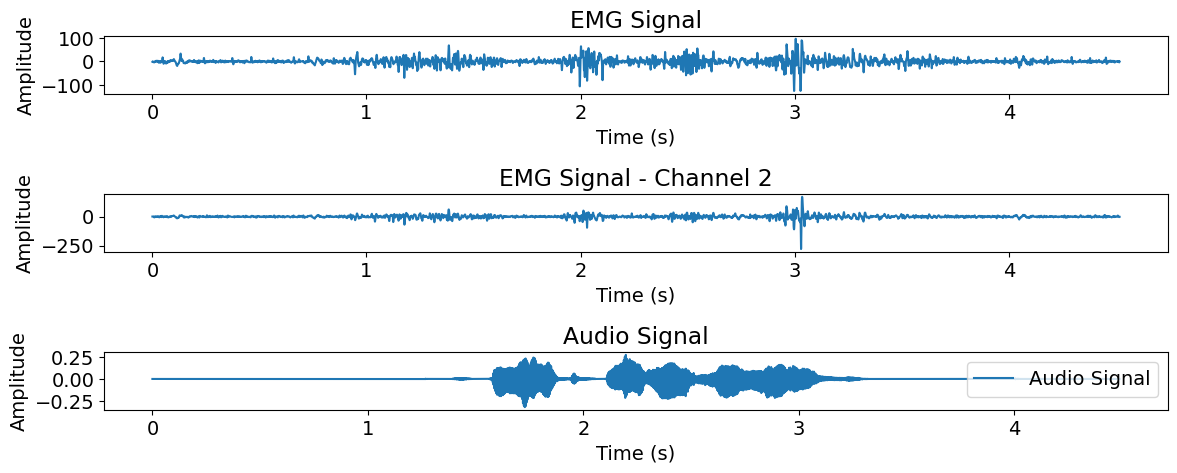

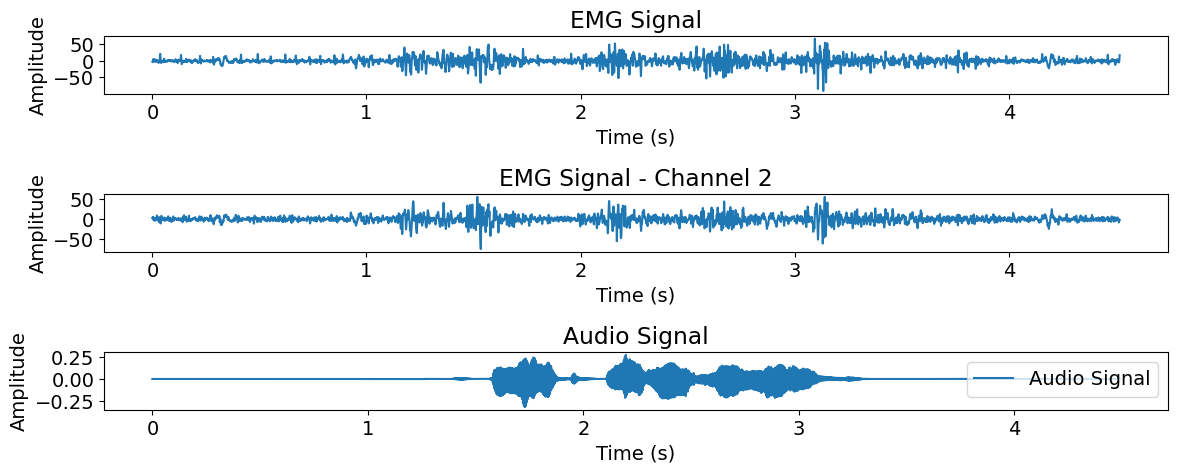

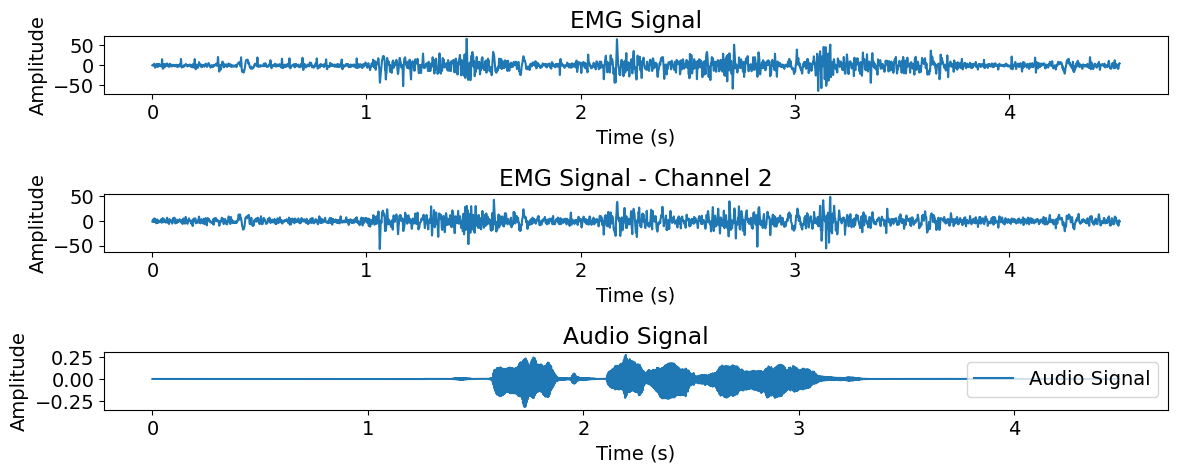

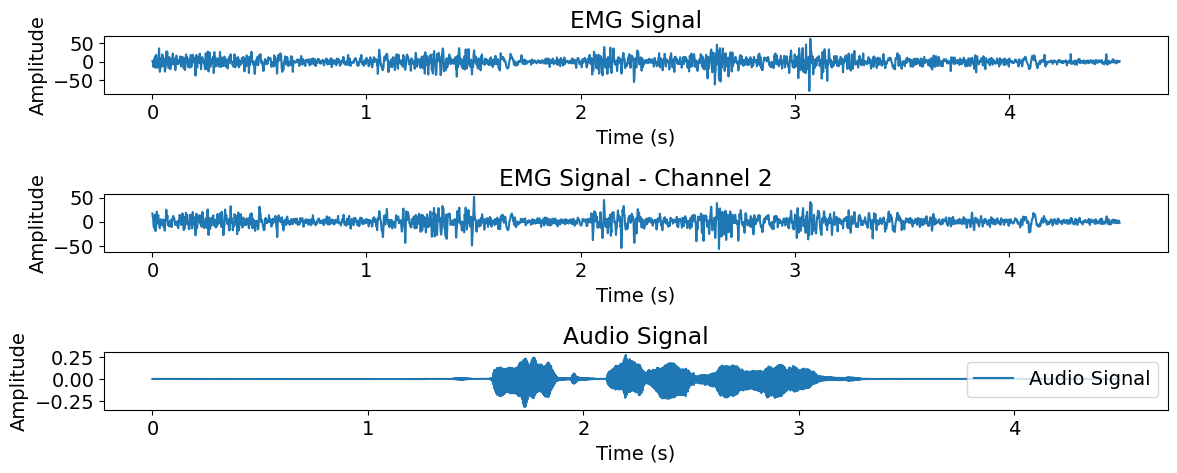

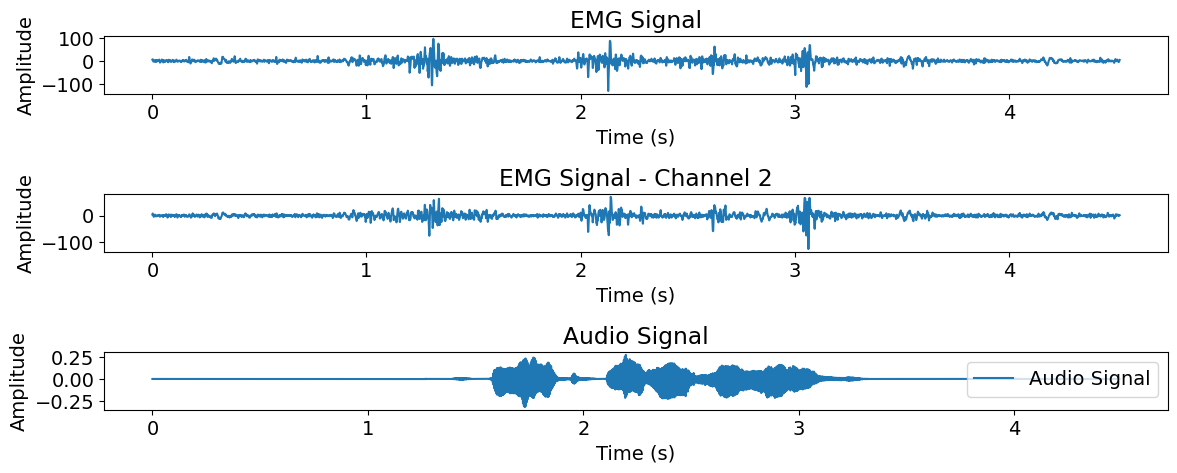

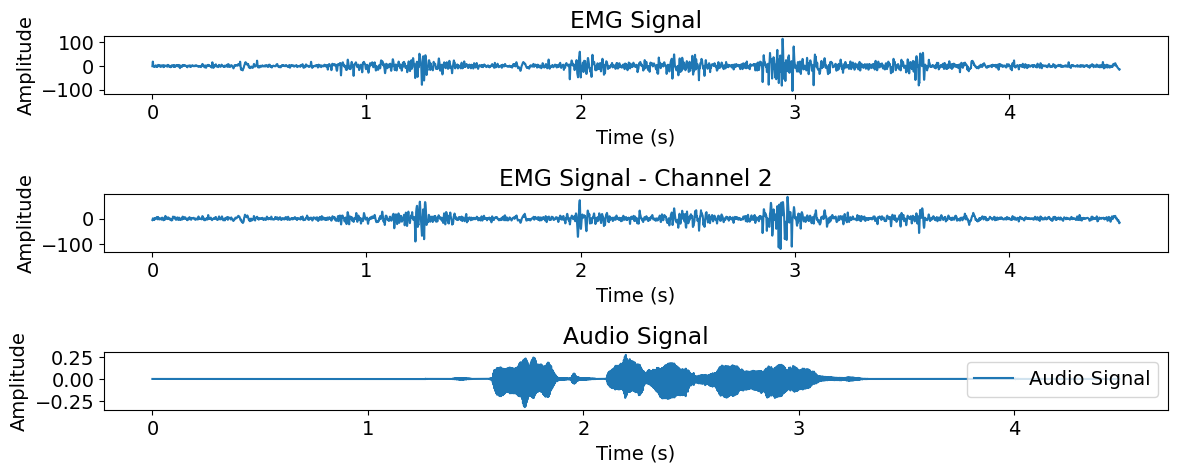

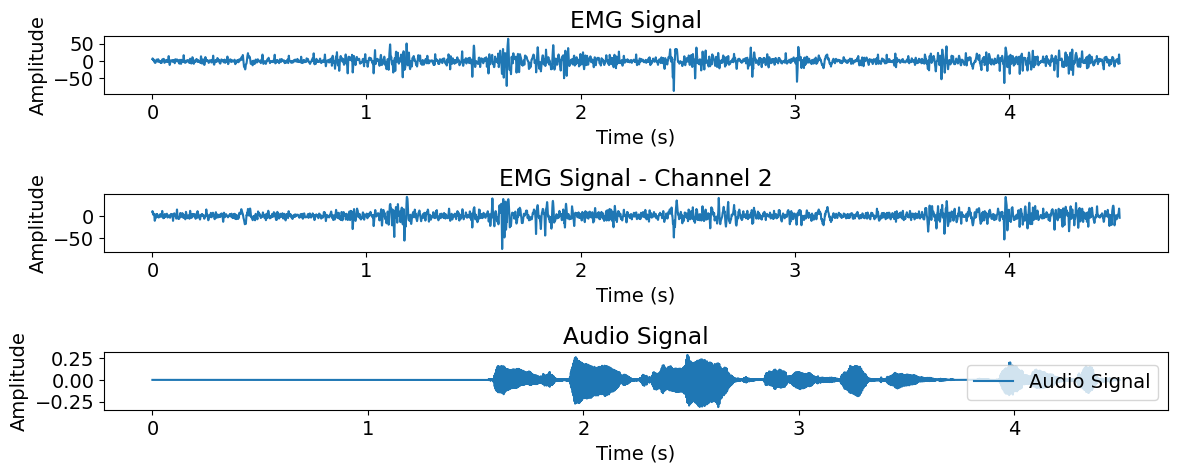

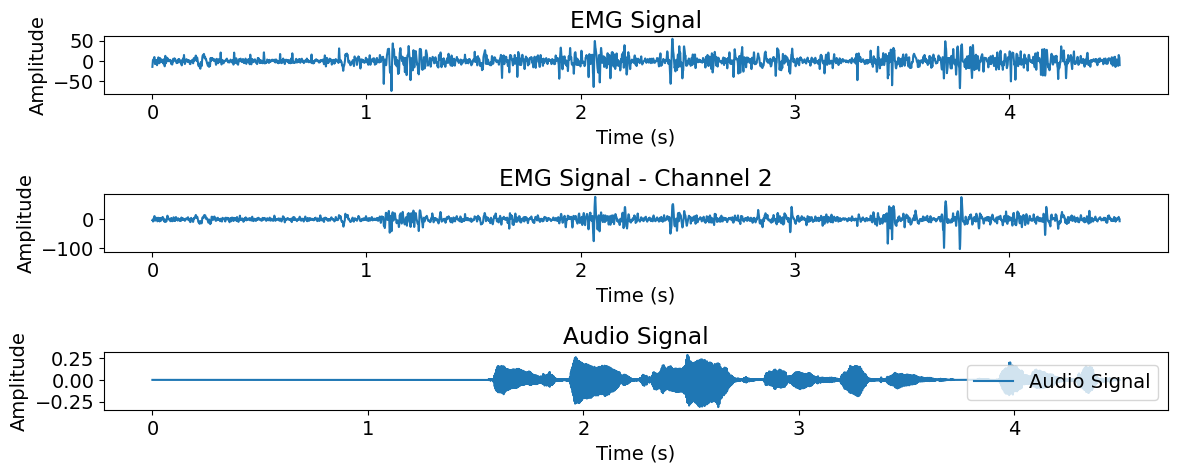

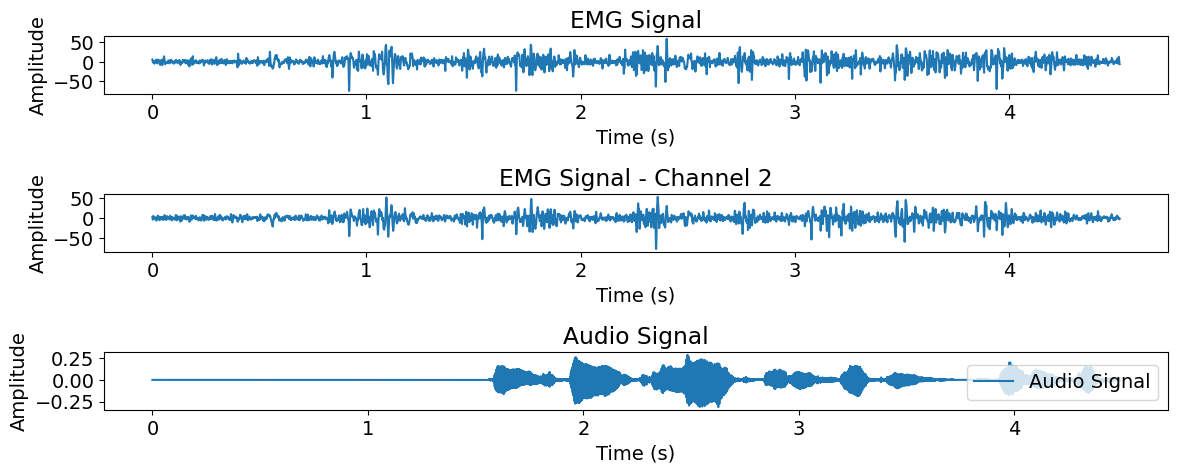

In [14]:
for i in range(len(utterances_audio_silent[:10])):
    #create t_emg and t_audio vectors using linspace    
    t_emg = np.linspace(start_ts_emg - start_ts_emg, stop_ts_emg - start_ts_emg, utterances_emg_silent[i].shape[0])
    t_audio = np.linspace(start_ts_audio - start_ts_audio, stop_ts_audio - start_ts_audio, utterances_audio_silent[i].shape[0])
    # t_trigger = np.linspace(start_ts - start_ts, stop_ts - start_ts, trigger.shape[0])
    #create t_emg and t_audio vectors using np arange, do no tuse ts
    # t_emg = np.arange(0, emg_signal.shape[0] / emg_data["emg"]["fs"], 1 / emg_data["emg"]["fs"])
    # t_audio = np.arange(0, audio_signal.shape[0] / audio_data["audio"]["fs"], 1 / audio_data["audio"]["fs"])
    min_amplitude = -100
    max_amplitude = 100
    #plot the emg signal and audio signal using subplots, separate the two emg channels in tow subplots and the audio signal in a third subplot
    plt.rcParams.update({'font.size': 14})  # Set default font size for plots
    plt.figure(figsize=(12, 6))
    plt.subplot(4, 1, 1)
    plt.plot(t_emg, utterances_emg_silent[i][:, 4], label='EMG Channel 1')
    plt.title('EMG Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    #add ylim to the plot
    # plt.ylim(min_amplitude, max_amplitude)
    # plt.legend()
    plt.subplot(4, 1, 2)
    plt.plot(t_emg, utterances_emg_silent[i][:, 3], label='EMG Channel 2')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    # plt.ylim(min_amplitude, max_amplitude)
    # plt.legend()
    plt.title('EMG Signal - Channel 2')

    plt.subplot(4, 1, 3)
    plt.plot(t_audio, utterances_audio_silent[i][:, 0], label='Audio Signal')
    plt.title('Audio Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()

    # plt.subplot(4, 1, 4)
    # plt.plot(t_trigger, trigger, label='Trigger Signal')
    # plt.title('Trigger Signal')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Amplitude')
    # # plt.legend()

    plt.show()

In [ ]:
# write the function to write wav you can use scipy.io.wavfile.write
from scipy.io import wavfile
def write_wav(filename: str, data: np.ndarray, fs: float):
    """
    Write a WAV file.

    Parameters
    ----------
    filename : str
        The name of the file to write.
    data : np.ndarray
        The audio data to write.
    fs : float
        The sampling frequency of the audio data.
    """
    wavfile.write(filename, int(fs), data.astype(np.float32))


In [32]:
# use librosa to write the audio signal to a wav file using soundfile backend
import soundfile as sf
def write_wav_librosa(filename: str, data: np.ndarray, fs: float):
    """
    Write a WAV file using librosa.

    Parameters
    ----------
    filename : str
        The name of the file to write.
    data : np.ndarray
        The audio data to write.
    fs : float
        The sampling frequency of the audio data.
    """
    y =  (data * 32767).astype('int16')
    sf.write(filename, y, int(fs), format='WAV')

In [33]:
import os
#create a list with the nato alphabet up to delta
nato_alphabet = [
    "Alfa",
    "Bravo",
    "Charlie",
    "Delta",
    "Echo",
    "Foxtrot",
    "Golf",
    "Hotel",
    "India",
    "Juliett",
    "Kilo",
    "Lima",
    "Mike",
    "November",
    "Oscar",
    "Papa",
    "Quebec",
    "Romeo",
    "Sierra",
    "Tango",
    "Uniform",
    "Victor",
    "Whiskey",
    "Xray",
    "Yankee",
    "Zulu"
    
]
# create a dictionary to map the trigger values to the nato alphabet
trigger_map = {i + 1: nato_alphabet[i] for i in range(len(nato_alphabet))}
# save the emg in a npy file, save a file for each utterance, some utterances trigger values are the same so put a number at the end of the file name
#put a number after name on the same values inside trigger_values, the number should restart from 1 for each value, create the file if not exists
path = f"C:/Users/pierangelo/Documents/silent_speech/modified/full_nato_10reps_diff_silent_grace"
if not os.path.exists(f"{path}/audio"):
    os.makedirs(f"{path}/audio")
if not os.path.exists(f"{path}/emg"):
    os.makedirs(f"{path}/emg")
num_file = 1
for i, trigger_value in enumerate(np.unique(trigger_values)):
    num_file = 1
    for j in range(len(trigger_values)):
        if trigger_values[j] == trigger_value:
            write_wav_librosa(f"{path}/audio/{trigger_map[trigger_values[j]]}_{num_file}.wav", utterances_audio[j][:,0], 48000)
            np.save(f"{path}/emg/{trigger_map[trigger_values[j]]}_{num_file}.npy", utterances_emg[j])
            num_file += 1

In [ ]:
import os
#create a list with the nato alphabet up to delta
nato_alphabet = [
    "Alfa",
    "Bravo"
    
]
# create a dictionary to map the trigger values to the nato alphabet
trigger_map = {i + 1: nato_alphabet[i] for i in range(len(nato_alphabet))}
# save the emg in a npy file, save a file for each utterance, some utterances trigger values are the same so put a number at the end of the file name
#put a number after name on the same values inside trigger_values, the number should restart from 1 for each value, create the file if not exists
path = f"C:/Users/pierangelo/Documents/silent_speech/alfa_bravo_4reps_diff_ref_pierangelo"
if not os.path.exists(f"{path}/audio"):
    os.makedirs(f"{path}/audio")
if not os.path.exists(f"{path}/emg"):
    os.makedirs(f"{path}/emg")
num_file = 1
for i, trigger_value in enumerate(np.unique(trigger_values)):
    num_file = 1
    for j in range(len(trigger_values)):
        if trigger_values[j] == trigger_value:
            write_wav_librosa(f"{path}/audio/{trigger_map[trigger_values[j]]}_{num_file}.wav", utterances_audio[j][:,0], 48000)
            np.save(f"{path}/emg/{trigger_map[trigger_values[j]]}_{num_file}.npy", utterances_emg[j])
            num_file += 1